 # 🎂 Bitcoin Birth Date Search



 Поиск оптимальной даты рождения Bitcoin через перебор всех 365 дней года.



 ## Идея:

 - Bitcoin был создан в 2009 году, но точная "дата рождения" неизвестна

 - Возможные варианты: genesis block (03.01.2009), whitepaper (31.10.2008), etc.

 - Мы перебираем ВСЕ 365 дней и смотрим какая дата даёт лучшую модель



 ## Фаза 1: Только транзиты

 - Используем ТОЛЬКО транзиты к натальной карте субъекта

 - НЕ используем аспекты между транзитными планетами



 ## Фаза 2: Транзиты + лучший baseline

 - Добавляем транзиты к лучшей модели из hyperparameter search

 ## 1. Setup

In [1]:
import sys
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path("/home/rut/ostrofun")
sys.path.insert(0, str(PROJECT_ROOT))


In [2]:
# Import all modules
from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data
from RESEARCH.labeling import create_balanced_labels
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates,
    calculate_bodies_for_dates_multi,
    calculate_aspects_for_dates,
    calculate_transits_for_dates,
    calculate_phases_for_dates,
    get_natal_bodies,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    tune_threshold,
    predict_with_threshold,
    check_cuda_available,
)
from RESEARCH.grid_search import evaluate_combo
from RESEARCH.visualization import plot_confusion_matrix

import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from itertools import product
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print("✓ All modules imported")


✓ All modules imported


 ## 2. Configuration

In [3]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🎂 НАСТРОЙКИ ПОИСКА ДАТЫ РОЖДЕНИЯ
# ══════════════════════════════════════════════════════════════════════════════════

# Год рождения Bitcoin (перебираем все дни этого года)
BIRTH_YEAR = 2009  # Genesis block год

# Диапазон дат для поиска
# Можно ограничить если есть предположения
SEARCH_START = date(BIRTH_YEAR, 1, 1)   # С 1 января
SEARCH_END = date(BIRTH_YEAR, 12, 31)    # По 31 декабря

# Известные даты-кандидаты Bitcoin (для приоритетной проверки)
CANDIDATE_DATES = [
    date(2009, 1, 3),   # Genesis Block mined
    date(2009, 1, 9),   # First Bitcoin software release
    date(2009, 1, 12),  # First Bitcoin transaction (Satoshi → Hal Finney)
    date(2008, 10, 31), # Whitepaper published
    date(2008, 8, 18),  # bitcoin.org domain registered
]

# ══════════════════════════════════════════════════════════════════════════════════
# 🎯 ЛУЧШИЕ ПАРАМЕТРЫ ИЗ HYPERPARAMETER SEARCH
# ══════════════════════════════════════════════════════════════════════════════════
# Эти параметры используются для модели

BEST_ASTRO_CONFIG = {
    "coord_mode": "both",      # geo + helio координаты
    "orb_mult": 0.15,          # Орбис для аспектов
    "gauss_window": 300,       # Гаусс окно для меток
    "gauss_std": 70.0,         # Гаусс std для меток
    "exclude_bodies": None,    # Все тела включены
}

BEST_XGB_PARAMS = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 50,
}

print(f"🎂 Search range: {SEARCH_START} → {SEARCH_END}")
print(f"   Total days: {(SEARCH_END - SEARCH_START).days + 1}")
print(f"   Known candidates: {len(CANDIDATE_DATES)}")


🎂 Search range: 2009-01-01 → 2009-12-31
   Total days: 365
   Known candidates: 5


 ## 3. Load Data

In [4]:
# Load market data
df_market = load_market_data()
DATA_START = "2017-11-01"
df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)

print(f"Market data: {len(df_market)} rows")
print(f"Date range: {df_market['date'].min().date()} → {df_market['date'].max().date()}")


Loaded 5677 rows from DB for subject=btc
Date range: 2010-07-18 -> 2026-01-31
Market data: 3014 rows
Date range: 2017-11-01 → 2026-01-31


In [5]:
# Create labels
df_labels = create_balanced_labels(
    df_market,
    gauss_window=BEST_ASTRO_CONFIG["gauss_window"],
    gauss_std=BEST_ASTRO_CONFIG["gauss_std"],
)

print(f"Labels: {len(df_labels)} rows")
print(f"Distribution: {df_labels['target'].value_counts().to_dict()}")


Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Labels: 1506 rows
Distribution: {0: 753, 1: 753}


In [6]:
# Initialize ephemeris
settings = init_ephemeris()
_, device = check_cuda_available()
print(f"Device: {device}")


Device: cuda


 ## 4. Pre-compute Transit Bodies

In [7]:
# Вычисляем позиции транзитных планет для всех дат (один раз)
print("📍 Pre-computing transit body positions...")

if BEST_ASTRO_CONFIG["coord_mode"] == "geo":
    df_bodies, bodies_by_date = calculate_bodies_for_dates(
        df_market["date"], settings, progress=True
    )
else:
    df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
        df_market["date"], settings, 
        coord_mode=BEST_ASTRO_CONFIG["coord_mode"], 
        progress=True
    )
    bodies_by_date = geo_by_date if geo_by_date else helio_by_date

print(f"✓ Transit bodies: {len(df_bodies)} rows")


📍 Pre-computing transit body positions...
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 16318.29it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 28941.60it/s]

✅ Объединено: 78364 записей из 2 систем координат
✓ Transit bodies: 78364 rows


In [8]:
# Вычисляем фазы Луны и элонгации планет
print("\n🌙 Computing moon phases and elongations...")
df_phases = calculate_phases_for_dates(bodies_by_date, progress=True)
print(f"✓ Phases: {len(df_phases)} rows")



🌙 Computing moon phases and elongations...


Calculating phases & elongations: 100%|██████████| 3014/3014 [00:00<00:00, 222200.13it/s]

✅ Рассчитано 3014 дней: фаза Луны + элонгации планет
✓ Phases: 3014 rows


 ## 5. Birth Date Evaluation Function

In [9]:
def evaluate_birthdate(
    birth_date: date,
    df_market: pd.DataFrame,
    df_labels: pd.DataFrame,
    bodies_by_date: dict,
    df_phases: pd.DataFrame,
    settings,
    config: dict,
    xgb_params: dict,
    device: str,
    use_pair_aspects: bool = False,  # Фаза 1: False, Фаза 2: True
) -> dict:
    """
    Оценка одной даты рождения.
    
    Возвращает метрики модели обученной на транзитах к этой дате.
    """
    try:
        # 1. Получаем натальные позиции для этой даты
        # Конвертируем date в строку ISO формата (полночь)
        birth_dt_str = f"{birth_date.isoformat()}T12:00:00"  # Полдень UTC
        natal_bodies = get_natal_bodies(birth_dt_str, settings)
        
        # 2. Вычисляем транзиты к натальным позициям
        df_transits = calculate_transits_for_dates(
            bodies_by_date, natal_bodies, settings,
            orb_mult=config["orb_mult"],
            progress=False,
        )
        
        if len(df_transits) == 0:
            return {"error": "No transits found", "birth_date": birth_date}
        
        # 3. Вычисляем аспекты между планетами (если Фаза 2)
        df_aspects = None
        if use_pair_aspects:
            df_aspects = calculate_aspects_for_dates(
                bodies_by_date, settings,
                orb_mult=config["orb_mult"],
                progress=False,
            )
        
        # 4. Строим признаки
        df_features = build_full_features(
            df_bodies,
            df_aspects,  # None для Фазы 1
            df_transits=df_transits,  # Транзиты к натальной карте
            df_phases=df_phases,
            include_pair_aspects=use_pair_aspects,
            include_transit_aspects=True,  # Всегда включаем транзиты
            exclude_bodies=config["exclude_bodies"],
        )
        
        # 5. Merge с метками
        df_dataset = merge_features_with_labels(df_features, df_labels)
        
        if len(df_dataset) < 100:
            return {"error": "Too few samples", "birth_date": birth_date}
        
        # 6. Split
        train_df, val_df, test_df = split_dataset(df_dataset)
        feature_cols = [c for c in df_dataset.columns if c not in ["date", "target"]]
        
        X_train, y_train = prepare_xy(train_df, feature_cols)
        X_val, y_val = prepare_xy(val_df, feature_cols)
        X_test, y_test = prepare_xy(test_df, feature_cols)
        
        # 7. Train model
        model = train_xgb_model(
            X_train, y_train, X_val, y_val,
            feature_cols, n_classes=2, device=device,
            **xgb_params
        )
        
        # 8. Tune threshold
        best_t, _ = tune_threshold(model, X_val, y_val, metric="recall_min")
        
        # 9. Predict on test
        y_pred = predict_with_threshold(model, X_test, threshold=best_t)
        
        # 10. Metrics
        report = classification_report(
            y_test, y_pred, labels=[0, 1],
            target_names=["DOWN", "UP"], output_dict=True, zero_division=0
        )
        
        recall_down = report["DOWN"]["recall"]
        recall_up = report["UP"]["recall"]
        mcc = matthews_corrcoef(y_test, y_pred)
        
        return {
            "birth_date": birth_date,
            "recall_down": recall_down,
            "recall_up": recall_up,
            "recall_min": min(recall_down, recall_up),
            "recall_gap": abs(recall_down - recall_up),
            "mcc": mcc,
            "threshold": best_t,
            "n_features": len(feature_cols),
            "n_transits": len(df_transits),
        }
        
    except Exception as e:
        return {"error": str(e), "birth_date": birth_date}


 ## 6. Phase 1: Transits Only Search

In [10]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🔍 ФАЗА 1: ПОИСК ДАТЫ РОЖДЕНИЯ (ТОЛЬКО ТРАНЗИТЫ)
# ══════════════════════════════════════════════════════════════════════════════════
# 
# Модель обучается ТОЛЬКО на:
# - Транзиты к натальной карте субъекта
# - Фазы Луны и элонгации планет
# - Позиции транзитных планет
#
# НЕ включает:
# - Аспекты между транзитными планетами

print("=" * 80)
print("🎂 PHASE 1: BIRTH DATE SEARCH (TRANSITS ONLY)")
print("=" * 80)
print(f"   Search range: {SEARCH_START} → {SEARCH_END}")
print(f"   Model params: {BEST_XGB_PARAMS}")
print()


🎂 PHASE 1: BIRTH DATE SEARCH (TRANSITS ONLY)
   Search range: 2009-01-01 → 2009-12-31
   Model params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stopping_rounds': 50}



In [11]:
# Сначала проверяем известных кандидатов
print("🎯 Testing known candidate dates first...")
candidate_results = []

for birth_date in CANDIDATE_DATES:
    if not (SEARCH_START <= birth_date <= SEARCH_END or birth_date.year == 2008):
        # Для 2008 года всё равно тестируем
        pass
    
    result = evaluate_birthdate(
        birth_date, df_market, df_labels, bodies_by_date, df_phases,
        settings, BEST_ASTRO_CONFIG, BEST_XGB_PARAMS, device,
        use_pair_aspects=False,  # Фаза 1: только транзиты
    )
    candidate_results.append(result)
    
    if "error" not in result:
        print(f"   {birth_date}: R_MIN={result['recall_min']:.3f} MCC={result['mcc']:.3f}")
    else:
        print(f"   {birth_date}: ERROR - {result['error']}")


🎯 Testing known candidate dates first...
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.51, RECALL_MIN=0.4680, gap=0.1006
   2009-01-03: R_MIN=0.565 MCC=0.183
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.50, RECALL_MIN=0.5040, gap=0.0477
   2009-01-09: R_MIN=0.548 MCC=0.147
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.1225
   2009-01-12: R_MIN=0.401 MCC=0.144
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.0383
   2008-10-31: R_MIN=0.343 MCC=0.095
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.1024
   200

In [12]:
# Полный перебор всех дней года
print(f"\n🔢 Full search: {(SEARCH_END - SEARCH_START).days + 1} days...")

results_phase1 = []
best_so_far = {"recall_min": 0, "birth_date": None}

current_date = SEARCH_START
with tqdm(total=(SEARCH_END - SEARCH_START).days + 1, desc="Birth date search") as pbar:
    while current_date <= SEARCH_END:
        result = evaluate_birthdate(
            current_date, df_market, df_labels, bodies_by_date, df_phases,
            settings, BEST_ASTRO_CONFIG, BEST_XGB_PARAMS, device,
            use_pair_aspects=False,
        )
        results_phase1.append(result)
        
        if "error" not in result:
            r_min = result["recall_min"]
            if r_min > best_so_far["recall_min"]:
                best_so_far["recall_min"] = r_min
                best_so_far["mcc"] = result["mcc"]
                best_so_far["birth_date"] = current_date
                tqdm.write(f"🏆 NEW BEST: {current_date} → R_MIN={r_min:.3f} MCC={result['mcc']:.3f}")
        
        current_date += timedelta(days=1)
        pbar.update(1)



🔢 Full search: 365 days...


Birth date search:   0%|          | 0/365 [00:00<?, ?it/s]

Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:   0%|          | 1/365 [00:00<06:00,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5320, gap=0.0083
🏆 NEW BEST: 2009-01-01 → R_MIN=0.570 MCC=0.142
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:   1%|          | 2/365 [00:01<05:56,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4879, gap=0.0392
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   1%|          | 3/365 [00:02<05:55,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4680, gap=0.1006
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:   1%|          | 4/365 [00:03<05:45,  1.04it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.5172, gap=0.0231
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:   1%|▏         | 5/365 [00:04<05:42,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0405
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:   2%|▏         | 6/365 [00:05<05:47,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.0750
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:   2%|▏         | 7/365 [00:06<05:59,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5081, gap=0.0240
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:   2%|▏         | 8/365 [00:07<05:59,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4483, gap=0.0961
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:   2%|▏         | 9/365 [00:08<05:53,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5040, gap=0.0477
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:   3%|▎         | 10/365 [00:09<05:56,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1109
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:   3%|▎         | 11/365 [00:11<06:15,  1.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.0791
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:   3%|▎         | 12/365 [00:12<06:05,  1.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.1225
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   4%|▎         | 13/365 [00:13<05:56,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5040, gap=0.0181
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:   4%|▍         | 14/365 [00:13<05:45,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4435, gap=0.1821
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:   4%|▍         | 15/365 [00:14<05:37,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.0549
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:   4%|▍         | 16/365 [00:15<05:38,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0110
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   5%|▍         | 17/365 [00:16<05:30,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4597, gap=0.1315
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   5%|▍         | 18/365 [00:17<05:24,  1.07it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0379
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:   5%|▌         | 19/365 [00:18<05:18,  1.08it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5320, gap=0.0083
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:   5%|▌         | 20/365 [00:19<05:21,  1.07it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5363, gap=0.0154
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   6%|▌         | 21/365 [00:20<05:28,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4718, gap=0.1095
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   6%|▌         | 22/365 [00:21<05:34,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.0334
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   6%|▋         | 23/365 [00:22<05:40,  1.00it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.0826
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:   7%|▋         | 24/365 [00:23<05:41,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0468
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:   7%|▋         | 25/365 [00:24<05:44,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.0670
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:   7%|▋         | 26/365 [00:25<05:41,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0576
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:   7%|▋         | 27/365 [00:26<05:39,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0284
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:   8%|▊         | 28/365 [00:27<05:33,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5202, gap=0.0365
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:   8%|▊         | 29/365 [00:28<05:24,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4435, gap=0.1328
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:   8%|▊         | 30/365 [00:29<05:15,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0531
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:   8%|▊         | 31/365 [00:30<05:16,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5074, gap=0.0491
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:   9%|▉         | 32/365 [00:31<05:24,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4315, gap=0.1745
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:   9%|▉         | 33/365 [00:32<05:49,  1.05s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4975, gap=0.0750
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:   9%|▉         | 34/365 [00:33<05:51,  1.06s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.3990, gap=0.2703
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  10%|▉         | 35/365 [00:34<05:33,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4476, gap=0.1386
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  10%|▉         | 36/365 [00:35<05:34,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5121, gap=0.0347
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  10%|█         | 37/365 [00:36<05:39,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0970
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  10%|█         | 38/365 [00:37<05:26,  1.00it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4532, gap=0.1234
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  11%|█         | 39/365 [00:38<05:19,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4274, gap=0.1883
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  11%|█         | 40/365 [00:39<05:28,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.1386
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1314
Split: Train=2107, Val=451, Test=452


Birth date search:  11%|█         | 41/365 [00:40<05:23,  1.00it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.1077
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  12%|█▏        | 42/365 [00:41<05:19,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.1503
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  12%|█▏        | 43/365 [00:42<05:26,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0737
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  12%|█▏        | 44/365 [00:43<05:24,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.0571
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1318
Split: Train=2107, Val=451, Test=452


Birth date search:  12%|█▏        | 45/365 [00:44<05:14,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4718, gap=0.0750
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  13%|█▎        | 46/365 [00:45<05:15,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0051
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1318
Split: Train=2107, Val=451, Test=452


Birth date search:  13%|█▎        | 47/365 [00:46<05:05,  1.04it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4919, gap=0.0746
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1306
Split: Train=2107, Val=451, Test=452


Birth date search:  13%|█▎        | 48/365 [00:47<05:10,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4718, gap=0.1588
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1312
Split: Train=2107, Val=451, Test=452


Birth date search:  13%|█▎        | 49/365 [00:48<05:10,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5081, gap=0.0584
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  14%|█▎        | 50/365 [00:49<05:02,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0768
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  14%|█▍        | 51/365 [00:50<04:55,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4581, gap=0.0903
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1318
Split: Train=2107, Val=451, Test=452


Birth date search:  14%|█▍        | 52/365 [00:51<04:56,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4384, gap=0.1301
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1312
Split: Train=2107, Val=451, Test=452


Birth date search:  15%|█▍        | 53/365 [00:52<05:01,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.1014
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1310
Split: Train=2107, Val=451, Test=452


Birth date search:  15%|█▍        | 54/365 [00:53<05:04,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4532, gap=0.1113
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1310
Split: Train=2107, Val=451, Test=452


Birth date search:  15%|█▌        | 55/365 [00:54<05:02,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0612
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1314
Split: Train=2107, Val=451, Test=452


Birth date search:  15%|█▌        | 56/365 [00:55<04:50,  1.07it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.0204
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  16%|█▌        | 57/365 [00:56<04:53,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.3793, gap=0.3304
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1312
Split: Train=2107, Val=451, Test=452


Birth date search:  16%|█▌        | 58/365 [00:57<04:54,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.1521
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1314
Split: Train=2107, Val=451, Test=452


Birth date search:  16%|█▌        | 59/365 [00:57<04:50,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5040, gap=0.0428
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1318
Split: Train=2107, Val=451, Test=452


Birth date search:  16%|█▋        | 60/365 [00:59<05:04,  1.00it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0513
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  17%|█▋        | 61/365 [00:59<04:55,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4975, gap=0.0307
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1312
Split: Train=2107, Val=451, Test=452


Birth date search:  17%|█▋        | 62/365 [01:01<05:00,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1404
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1308
Split: Train=2107, Val=451, Test=452


Birth date search:  17%|█▋        | 63/365 [01:02<05:07,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.0056
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  18%|█▊        | 64/365 [01:02<04:54,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5025, gap=0.0096
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1318
Split: Train=2107, Val=451, Test=452


Birth date search:  18%|█▊        | 65/365 [01:03<04:49,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4778, gap=0.0706
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  18%|█▊        | 66/365 [01:04<04:47,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0611
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1318
Split: Train=2107, Val=451, Test=452


Birth date search:  18%|█▊        | 67/365 [01:05<04:41,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0128
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1318
Split: Train=2107, Val=451, Test=452


Birth date search:  19%|█▊        | 68/365 [01:06<04:58,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4597, gap=0.0773
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  19%|█▉        | 69/365 [01:07<04:52,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4877, gap=0.0244
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1324
Split: Train=2107, Val=451, Test=452


Birth date search:  19%|█▉        | 70/365 [01:08<04:46,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0249
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  19%|█▉        | 71/365 [01:09<04:40,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4597, gap=0.1019
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1314
Split: Train=2107, Val=451, Test=452


Birth date search:  20%|█▉        | 72/365 [01:10<04:47,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4433, gap=0.0405
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  20%|██        | 73/365 [01:11<04:48,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4879, gap=0.0540
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  20%|██        | 74/365 [01:12<04:56,  1.02s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5242, gap=0.0128
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  21%|██        | 75/365 [01:13<04:56,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4384, gap=0.1624
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  21%|██        | 76/365 [01:14<04:50,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0365
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1324
Split: Train=2107, Val=451, Test=452


Birth date search:  21%|██        | 77/365 [01:15<04:39,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.2188
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1324
Split: Train=2107, Val=451, Test=452


Birth date search:  21%|██▏       | 78/365 [01:16<04:33,  1.05it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.5081, gap=0.0929
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  22%|██▏       | 79/365 [01:17<04:31,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0665
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  22%|██▏       | 80/365 [01:18<04:29,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4433, gap=0.1292
🏆 NEW BEST: 2009-03-21 → R_MIN=0.574 MCC=0.164
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  22%|██▏       | 81/365 [01:19<04:29,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0096
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  22%|██▏       | 82/365 [01:20<04:35,  1.03it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.4828, gap=0.0455
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  23%|██▎       | 83/365 [01:21<04:32,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.0943
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  23%|██▎       | 84/365 [01:22<04:35,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4433, gap=0.1534
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1324
Split: Train=2107, Val=451, Test=452


Birth date search:  23%|██▎       | 85/365 [01:23<04:33,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5172, gap=0.0029
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  24%|██▎       | 86/365 [01:24<04:31,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.1064
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  24%|██▍       | 87/365 [01:25<04:23,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4631, gap=0.0611
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  24%|██▍       | 88/365 [01:26<04:22,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.0912
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  24%|██▍       | 89/365 [01:27<04:17,  1.07it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.1301
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  25%|██▍       | 90/365 [01:28<04:17,  1.07it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1032
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  25%|██▍       | 91/365 [01:28<04:11,  1.09it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.0822
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  25%|██▌       | 92/365 [01:29<04:09,  1.10it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0432
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  25%|██▌       | 93/365 [01:30<04:14,  1.07it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.4960, gap=0.0114
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  26%|██▌       | 94/365 [01:31<04:10,  1.08it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4286, gap=0.1400
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  26%|██▌       | 95/365 [01:32<04:12,  1.07it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0114
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  26%|██▋       | 96/365 [01:33<04:14,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.1503
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  27%|██▋       | 97/365 [01:34<04:12,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5040, gap=0.0083
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  27%|██▋       | 98/365 [01:35<04:05,  1.09it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.5123, gap=0.0441
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  27%|██▋       | 99/365 [01:36<04:06,  1.08it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0074
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  27%|██▋       | 100/365 [01:37<04:10,  1.06it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4926, gap=0.0074
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  28%|██▊       | 101/365 [01:38<04:13,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4187, gap=0.1700
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  28%|██▊       | 102/365 [01:39<04:07,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5320, gap=0.0083
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  28%|██▊       | 103/365 [01:40<04:04,  1.07it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.0638
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  28%|██▊       | 104/365 [01:41<04:02,  1.08it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4435, gap=0.1230
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  29%|██▉       | 105/365 [01:42<04:04,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4879, gap=0.0195
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  29%|██▉       | 106/365 [01:43<04:04,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5121, gap=0.0051
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  29%|██▉       | 107/365 [01:44<04:04,  1.06it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.4335, gap=0.1552
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  30%|██▉       | 108/365 [01:44<04:00,  1.07it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.0450
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  30%|██▉       | 109/365 [01:45<04:00,  1.07it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.1445
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  30%|███       | 110/365 [01:46<03:55,  1.08it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.1059
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  30%|███       | 111/365 [01:47<03:54,  1.08it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0208
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  31%|███       | 112/365 [01:48<03:56,  1.07it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4718, gap=0.0159
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  31%|███       | 113/365 [01:49<03:55,  1.07it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.0499
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  31%|███       | 114/365 [01:50<03:59,  1.05it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4919, gap=0.1041
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  32%|███▏      | 115/365 [01:51<04:03,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0101
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  32%|███▏      | 116/365 [01:52<04:16,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0051
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  32%|███▏      | 117/365 [01:53<04:16,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4960, gap=0.0213
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  32%|███▏      | 118/365 [01:54<04:19,  1.05s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4729, gap=0.0271
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  33%|███▎      | 119/365 [01:55<04:08,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.1145
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  33%|███▎      | 120/365 [01:56<04:00,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0007
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  33%|███▎      | 121/365 [01:57<03:57,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1256
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  33%|███▎      | 122/365 [01:58<03:55,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4516, gap=0.1543
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  34%|███▎      | 123/365 [01:59<03:50,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4433, gap=0.1413
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  34%|███▍      | 124/365 [02:00<03:49,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4828, gap=0.0455
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  34%|███▍      | 125/365 [02:01<03:52,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4433, gap=0.1534
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  35%|███▍      | 126/365 [02:02<03:51,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.3548, gap=0.3200
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  35%|███▍      | 127/365 [02:03<03:58,  1.00s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4395, gap=0.1368
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  35%|███▌      | 128/365 [02:04<03:57,  1.00s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.5000, gap=0.0271
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  35%|███▌      | 129/365 [02:05<04:01,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4286, gap=0.1763
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1324
Split: Train=2107, Val=451, Test=452


Birth date search:  36%|███▌      | 130/365 [02:06<03:57,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4839, gap=0.0629
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  36%|███▌      | 131/365 [02:07<03:54,  1.00s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4597, gap=0.0674
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  36%|███▌      | 132/365 [02:08<03:52,  1.00it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0070
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  36%|███▋      | 133/365 [02:09<03:58,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4476, gap=0.1288
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  37%|███▋      | 134/365 [02:10<03:53,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4839, gap=0.0137
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  37%|███▋      | 135/365 [02:11<03:50,  1.00s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0379
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  37%|███▋      | 136/365 [02:12<03:51,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5025, gap=0.0379
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  38%|███▊      | 137/365 [02:13<03:51,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4877, gap=0.0768
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  38%|███▊      | 138/365 [02:14<03:50,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4483, gap=0.1001
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  38%|███▊      | 139/365 [02:15<03:51,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4877, gap=0.0486
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  38%|███▊      | 140/365 [02:16<03:46,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4926, gap=0.0195
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  39%|███▊      | 141/365 [02:17<03:46,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0956
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  39%|███▉      | 142/365 [02:18<03:46,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5172, gap=0.0352
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  39%|███▉      | 143/365 [02:19<03:54,  1.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4286, gap=0.1642
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  39%|███▉      | 144/365 [02:20<03:43,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0777
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  40%|███▉      | 145/365 [02:21<03:38,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0298
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  40%|████      | 146/365 [02:22<03:36,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4631, gap=0.1136
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  40%|████      | 147/365 [02:23<03:48,  1.05s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0638
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  41%|████      | 148/365 [02:24<03:41,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4778, gap=0.0786
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  41%|████      | 149/365 [02:25<03:32,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.0992
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  41%|████      | 150/365 [02:26<03:34,  1.00it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0580
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  41%|████▏     | 151/365 [02:27<03:39,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5074, gap=0.0128
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  42%|████▏     | 152/365 [02:28<03:37,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4335, gap=0.1915
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  42%|████▏     | 153/365 [02:29<03:39,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.0728
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  42%|████▏     | 154/365 [02:31<03:42,  1.05s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.0728
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  42%|████▏     | 155/365 [02:32<03:43,  1.06s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.1055
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  43%|████▎     | 156/365 [02:33<03:33,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4335, gap=0.1270
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  43%|████▎     | 157/365 [02:34<03:32,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0790
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  43%|████▎     | 158/365 [02:35<03:31,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4680, gap=0.0804
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  44%|████▎     | 159/365 [02:36<03:33,  1.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5271, gap=0.0092
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  44%|████▍     | 160/365 [02:37<03:29,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0567
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  44%|████▍     | 161/365 [02:38<03:24,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0271
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  44%|████▍     | 162/365 [02:39<03:18,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5081, gap=0.0141
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  45%|████▍     | 163/365 [02:40<03:17,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1601
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  45%|████▍     | 164/365 [02:41<03:18,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5025, gap=0.0701
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  45%|████▌     | 165/365 [02:42<03:21,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4187, gap=0.2022
🏆 NEW BEST: 2009-06-14 → R_MIN=0.577 MCC=0.181
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  45%|████▌     | 166/365 [02:43<03:19,  1.00s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0835
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  46%|████▌     | 167/365 [02:44<03:21,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0486
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  46%|████▌     | 168/365 [02:45<03:20,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.0938
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  46%|████▋     | 169/365 [02:46<03:17,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.0598
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  47%|████▋     | 170/365 [02:47<03:12,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0755
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  47%|████▋     | 171/365 [02:48<03:09,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0755
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  47%|████▋     | 172/365 [02:49<03:13,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0710
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  47%|████▋     | 173/365 [02:50<03:18,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4516, gap=0.1198
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  48%|████▊     | 174/365 [02:51<03:17,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4476, gap=0.1041
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  48%|████▊     | 175/365 [02:52<03:19,  1.05s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4637, gap=0.1126
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  48%|████▊     | 176/365 [02:53<03:17,  1.05s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0674
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  48%|████▊     | 177/365 [02:54<03:20,  1.07s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0199
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  49%|████▉     | 178/365 [02:55<03:13,  1.03s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4532, gap=0.1274
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1356
Split: Train=2107, Val=451, Test=452


Birth date search:  49%|████▉     | 179/365 [02:56<03:11,  1.03s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5040, gap=0.0378
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  49%|████▉     | 180/365 [02:57<03:06,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1404
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  50%|████▉     | 181/365 [02:58<02:59,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4877, gap=0.0284
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  50%|████▉     | 182/365 [02:59<02:57,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4718, gap=0.1095
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  50%|█████     | 183/365 [03:00<03:03,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0051
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  50%|█████     | 184/365 [03:01<02:59,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5121, gap=0.0150
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  51%|█████     | 185/365 [03:02<03:00,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4597, gap=0.0871
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  51%|█████     | 186/365 [03:03<03:03,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0808
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  51%|█████     | 187/365 [03:04<03:08,  1.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0155
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  52%|█████▏    | 188/365 [03:05<02:59,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5271, gap=0.0213
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  52%|█████▏    | 189/365 [03:06<02:56,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4975, gap=0.0226
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  52%|█████▏    | 190/365 [03:07<02:52,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4828, gap=0.0374
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  52%|█████▏    | 191/365 [03:08<02:47,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4960, gap=0.1099
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  53%|█████▎    | 192/365 [03:09<02:43,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1194
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1356
Split: Train=2107, Val=451, Test=452


Birth date search:  53%|█████▎    | 193/365 [03:10<02:45,  1.04it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.5468, gap=0.0097
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  53%|█████▎    | 194/365 [03:11<02:45,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0450
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  53%|█████▎    | 195/365 [03:12<02:43,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0907
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  54%|█████▎    | 196/365 [03:13<02:40,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4680, gap=0.0844
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  54%|█████▍    | 197/365 [03:14<02:39,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4677, gap=0.0840
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  54%|█████▍    | 198/365 [03:14<02:39,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4778, gap=0.0867
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  55%|█████▍    | 199/365 [03:15<02:36,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4960, gap=0.0311
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  55%|█████▍    | 200/365 [03:16<02:40,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4631, gap=0.0571
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  55%|█████▌    | 201/365 [03:18<02:46,  1.02s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5040, gap=0.0181
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  55%|█████▌    | 202/365 [03:19<02:46,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4597, gap=0.0231
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  56%|█████▌    | 203/365 [03:20<02:46,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0593
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  56%|█████▌    | 204/365 [03:21<02:46,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5074, gap=0.0208
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  56%|█████▌    | 205/365 [03:22<02:44,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.1090
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  56%|█████▋    | 206/365 [03:23<02:41,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4089, gap=0.1637
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  57%|█████▋    | 207/365 [03:24<02:38,  1.00s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0939
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  57%|█████▋    | 208/365 [03:25<02:33,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5025, gap=0.0177
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  57%|█████▋    | 209/365 [03:25<02:28,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5123, gap=0.0199
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  58%|█████▊    | 210/365 [03:26<02:26,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4975, gap=0.0307
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  58%|█████▊    | 211/365 [03:27<02:25,  1.06it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.0983
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  58%|█████▊    | 212/365 [03:28<02:27,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0195
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  58%|█████▊    | 213/365 [03:29<02:24,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0643
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  59%|█████▊    | 214/365 [03:30<02:27,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4879, gap=0.0244
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  59%|█████▉    | 215/365 [03:31<02:23,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5202, gap=0.0020
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  59%|█████▉    | 216/365 [03:32<02:24,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.0777
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  59%|█████▉    | 217/365 [03:33<02:31,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4839, gap=0.0531
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  60%|█████▉    | 218/365 [03:34<02:30,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4778, gap=0.0786
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  60%|██████    | 219/365 [03:35<02:29,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4879, gap=0.0146
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  60%|██████    | 220/365 [03:36<02:27,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5271, gap=0.0334
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  61%|██████    | 221/365 [03:38<02:32,  1.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4975, gap=0.0871
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  61%|██████    | 222/365 [03:38<02:23,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.3024, gap=0.4316
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  61%|██████    | 223/365 [03:39<02:21,  1.00it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0419
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  61%|██████▏   | 224/365 [03:41<02:24,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0961
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  62%|██████▏   | 225/365 [03:42<02:23,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5320, gap=0.0164
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  62%|██████▏   | 226/365 [03:42<02:17,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4729, gap=0.0150
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  62%|██████▏   | 227/365 [03:43<02:14,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4879, gap=0.1328
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  62%|██████▏   | 228/365 [03:44<02:10,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5081, gap=0.0141
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  63%|██████▎   | 229/365 [03:45<02:10,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4778, gap=0.0746
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1366
Split: Train=2107, Val=451, Test=452


Birth date search:  63%|██████▎   | 230/365 [03:46<02:08,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4581, gap=0.0943
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  63%|██████▎   | 231/365 [03:47<02:10,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0876
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  64%|██████▎   | 232/365 [03:48<02:12,  1.00it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4680, gap=0.0885
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  64%|██████▍   | 233/365 [03:49<02:17,  1.04s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5040, gap=0.0674
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1370
Split: Train=2107, Val=451, Test=452


Birth date search:  64%|██████▍   | 234/365 [03:51<02:18,  1.06s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5323, gap=0.0293
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  64%|██████▍   | 235/365 [03:51<02:13,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.1077
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1366
Split: Train=2107, Val=451, Test=452


Birth date search:  65%|██████▍   | 236/365 [03:53<02:13,  1.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4677, gap=0.0988
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  65%|██████▍   | 237/365 [03:54<02:14,  1.05s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4729, gap=0.0714
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  65%|██████▌   | 238/365 [03:55<02:16,  1.07s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5320, gap=0.0043
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  65%|██████▌   | 239/365 [03:56<02:13,  1.06s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5040, gap=0.0132
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1356
Split: Train=2107, Val=451, Test=452


Birth date search:  66%|██████▌   | 240/365 [03:57<02:10,  1.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4335, gap=0.1471
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  66%|██████▌   | 241/365 [03:58<02:04,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.0840
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  66%|██████▋   | 242/365 [03:59<02:00,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.0840
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  67%|██████▋   | 243/365 [04:00<01:58,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4335, gap=0.1552
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  67%|██████▋   | 244/365 [04:01<02:01,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5025, gap=0.0177
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  67%|██████▋   | 245/365 [04:02<02:03,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4631, gap=0.0894
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  67%|██████▋   | 246/365 [04:03<02:00,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5081, gap=0.0486
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  68%|██████▊   | 247/365 [04:04<01:57,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.0920
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  68%|██████▊   | 248/365 [04:05<01:53,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4975, gap=0.0105
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  68%|██████▊   | 249/365 [04:05<01:50,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4274, gap=0.2080
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  68%|██████▊   | 250/365 [04:06<01:49,  1.05it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.4581, gap=0.0701
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  69%|██████▉   | 251/365 [04:07<01:46,  1.07it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4877, gap=0.0446
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  69%|██████▉   | 252/365 [04:08<01:47,  1.05it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1355
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  69%|██████▉   | 253/365 [04:09<01:47,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4476, gap=0.0697
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  70%|██████▉   | 254/365 [04:10<01:46,  1.04it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4680, gap=0.0199
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  70%|██████▉   | 255/365 [04:11<01:47,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4778, gap=0.0383
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  70%|███████   | 256/365 [04:12<01:47,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1453
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  70%|███████   | 257/365 [04:13<01:45,  1.03it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.4729, gap=0.0795
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  71%|███████   | 258/365 [04:14<01:43,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0051
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  71%|███████   | 259/365 [04:15<01:45,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0123
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  71%|███████   | 260/365 [04:16<01:42,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5121, gap=0.0495
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1372
Split: Train=2107, Val=451, Test=452


Birth date search:  72%|███████▏  | 261/365 [04:17<01:42,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5121, gap=0.0396
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1366
Split: Train=2107, Val=451, Test=452


Birth date search:  72%|███████▏  | 262/365 [04:18<01:45,  1.03s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4839, gap=0.0925
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1368
Split: Train=2107, Val=451, Test=452


Birth date search:  72%|███████▏  | 263/365 [04:19<01:48,  1.07s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.1064
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1370
Split: Train=2107, Val=451, Test=452


Birth date search:  72%|███████▏  | 264/365 [04:20<01:44,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0396
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1372
Split: Train=2107, Val=451, Test=452


Birth date search:  73%|███████▎  | 265/365 [04:21<01:41,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0876
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1366
Split: Train=2107, Val=451, Test=452


Birth date search:  73%|███████▎  | 266/365 [04:23<01:45,  1.07s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4435, gap=0.1525
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  73%|███████▎  | 267/365 [04:24<01:44,  1.07s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0365
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  73%|███████▎  | 268/365 [04:25<01:40,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5040, gap=0.0034
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  74%|███████▎  | 269/365 [04:26<01:39,  1.04s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.1064
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  74%|███████▍  | 270/365 [04:27<01:36,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5123, gap=0.0240
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  74%|███████▍  | 271/365 [04:28<01:35,  1.01s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4926, gap=0.0477
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1356
Split: Train=2107, Val=451, Test=452


Birth date search:  75%|███████▍  | 272/365 [04:29<01:33,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5222, gap=0.0020
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1356
Split: Train=2107, Val=451, Test=452


Birth date search:  75%|███████▍  | 273/365 [04:30<01:36,  1.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4039, gap=0.2251
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  75%|███████▌  | 274/365 [04:31<01:32,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4729, gap=0.0795
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  75%|███████▌  | 275/365 [04:32<01:31,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4384, gap=0.1180
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  76%|███████▌  | 276/365 [04:33<01:28,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4877, gap=0.0647
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  76%|███████▌  | 277/365 [04:34<01:27,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4631, gap=0.1055
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  76%|███████▌  | 278/365 [04:35<01:25,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4960, gap=0.0410
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  76%|███████▋  | 279/365 [04:36<01:26,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5222, gap=0.0141
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  77%|███████▋  | 280/365 [04:37<01:27,  1.03s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5040, gap=0.0625
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  77%|███████▋  | 281/365 [04:38<01:24,  1.00s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5025, gap=0.0621
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  77%|███████▋  | 282/365 [04:39<01:22,  1.00it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4975, gap=0.0025
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1364
Split: Train=2107, Val=451, Test=452


Birth date search:  78%|███████▊  | 283/365 [04:40<01:21,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.1364
🏆 NEW BEST: 2009-10-10 → R_MIN=0.578 MCC=0.205
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1372
Split: Train=2107, Val=451, Test=452


Birth date search:  78%|███████▊  | 284/365 [04:41<01:19,  1.01it/s]

🎯 Best threshold=0.52, RECALL_MIN=0.4631, gap=0.1015
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  78%|███████▊  | 285/365 [04:42<01:18,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4435, gap=0.1328
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1358
Split: Train=2107, Val=451, Test=452


Birth date search:  78%|███████▊  | 286/365 [04:43<01:18,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4828, gap=0.1019
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  79%|███████▊  | 287/365 [04:44<01:19,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4839, gap=0.0629
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1360
Split: Train=2107, Val=451, Test=452


Birth date search:  79%|███████▉  | 288/365 [04:45<01:20,  1.04s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4778, gap=0.0464
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1362
Split: Train=2107, Val=451, Test=452


Birth date search:  79%|███████▉  | 289/365 [04:46<01:20,  1.06s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5271, gap=0.0092
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  79%|███████▉  | 290/365 [04:47<01:18,  1.04s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.0858
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1356
Split: Train=2107, Val=451, Test=452


Birth date search:  80%|███████▉  | 291/365 [04:48<01:15,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0616
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1356
Split: Train=2107, Val=451, Test=452


Birth date search:  80%|████████  | 292/365 [04:49<01:12,  1.00it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.0719
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  80%|████████  | 293/365 [04:50<01:12,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4778, gap=0.0827
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  81%|████████  | 294/365 [04:51<01:10,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4194, gap=0.1521
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  81%|████████  | 295/365 [04:52<01:10,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4234, gap=0.1579
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  81%|████████  | 296/365 [04:53<01:12,  1.05s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.1153
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  81%|████████▏ | 297/365 [04:54<01:10,  1.04s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4631, gap=0.1095
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1350
Split: Train=2107, Val=451, Test=452


Birth date search:  82%|████████▏ | 298/365 [04:55<01:09,  1.04s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4597, gap=0.1610
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  82%|████████▏ | 299/365 [04:56<01:07,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4335, gap=0.1673
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  82%|████████▏ | 300/365 [04:57<01:04,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4476, gap=0.1436
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  82%|████████▏ | 301/365 [04:58<01:02,  1.03it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4236, gap=0.1812
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  83%|████████▎ | 302/365 [04:59<00:59,  1.06it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4919, gap=0.0647
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  83%|████████▎ | 303/365 [05:00<00:56,  1.10it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.3548, gap=0.3200
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  83%|████████▎ | 304/365 [05:01<01:02,  1.03s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1476
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  84%|████████▎ | 305/365 [05:02<01:04,  1.07s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4960, gap=0.0705
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  84%|████████▍ | 306/365 [05:03<01:00,  1.03s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.1086
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  84%|████████▍ | 307/365 [05:04<00:59,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4729, gap=0.0634
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  84%|████████▍ | 308/365 [05:05<00:57,  1.01s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5271, gap=0.0092
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  85%|████████▍ | 309/365 [05:06<00:57,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0396
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  85%|████████▍ | 310/365 [05:07<00:56,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4483, gap=0.0961
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  85%|████████▌ | 311/365 [05:08<00:54,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4879, gap=0.0638
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1354
Split: Train=2107, Val=451, Test=452


Birth date search:  85%|████████▌ | 312/365 [05:09<00:53,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4516, gap=0.1395
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  86%|████████▌ | 313/365 [05:10<00:53,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4637, gap=0.0732
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1346
Split: Train=2107, Val=451, Test=452


Birth date search:  86%|████████▌ | 314/365 [05:11<00:51,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.0670
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1348
Split: Train=2107, Val=451, Test=452


Birth date search:  86%|████████▋ | 315/365 [05:12<00:51,  1.04s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5222, gap=0.0101
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1352
Split: Train=2107, Val=451, Test=452


Birth date search:  87%|████████▋ | 316/365 [05:13<00:50,  1.02s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4729, gap=0.0876
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  87%|████████▋ | 317/365 [05:14<00:48,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4960, gap=0.0508
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1342
Split: Train=2107, Val=451, Test=452


Birth date search:  87%|████████▋ | 318/365 [05:15<00:47,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4236, gap=0.2255
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  87%|████████▋ | 319/365 [05:16<00:49,  1.07s/it]

🎯 Best threshold=0.48, RECALL_MIN=0.5202, gap=0.0020
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1340
Split: Train=2107, Val=451, Test=452


Birth date search:  88%|████████▊ | 320/365 [05:17<00:47,  1.05s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4926, gap=0.0074
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  88%|████████▊ | 321/365 [05:18<00:45,  1.04s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.0226
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  88%|████████▊ | 322/365 [05:19<00:45,  1.06s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4828, gap=0.0293
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  88%|████████▊ | 323/365 [05:21<00:44,  1.06s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4879, gap=0.0244
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  89%|████████▉ | 324/365 [05:22<00:45,  1.10s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4556, gap=0.1158
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  89%|████████▉ | 325/365 [05:23<00:43,  1.08s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4113, gap=0.1355
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  89%|████████▉ | 326/365 [05:24<00:43,  1.12s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4718, gap=0.1095
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  90%|████████▉ | 327/365 [05:25<00:40,  1.06s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4194, gap=0.1915
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1330
Split: Train=2107, Val=451, Test=452


Birth date search:  90%|████████▉ | 328/365 [05:26<00:37,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4729, gap=0.0876
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  90%|█████████ | 329/365 [05:27<00:37,  1.04s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5000, gap=0.0320
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  90%|█████████ | 330/365 [05:28<00:35,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4637, gap=0.1077
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  91%|█████████ | 331/365 [05:29<00:34,  1.00s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5000, gap=0.0665
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  91%|█████████ | 332/365 [05:30<00:32,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5040, gap=0.0378
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  91%|█████████ | 333/365 [05:31<00:31,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.5000, gap=0.0074
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  92%|█████████▏| 334/365 [05:32<00:30,  1.00it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.0661
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  92%|█████████▏| 335/365 [05:33<00:30,  1.00s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4355, gap=0.1606
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  92%|█████████▏| 336/365 [05:34<00:29,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4476, gap=0.0992
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  92%|█████████▏| 337/365 [05:35<00:28,  1.01s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5161, gap=0.0257
🏆 NEW BEST: 2009-12-03 → R_MIN=0.581 MCC=0.172
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  93%|█████████▎| 338/365 [05:36<00:27,  1.02s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5081, gap=0.0437
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  93%|█████████▎| 339/365 [05:37<00:25,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4960, gap=0.1395
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  93%|█████████▎| 340/365 [05:38<00:24,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.1104
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1310
Split: Train=2107, Val=451, Test=452


Birth date search:  93%|█████████▎| 341/365 [05:39<00:23,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5161, gap=0.0060
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1310
Split: Train=2107, Val=451, Test=452


Birth date search:  94%|█████████▎| 342/365 [05:40<00:22,  1.04it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4758, gap=0.1252
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1316
Split: Train=2107, Val=451, Test=452


Birth date search:  94%|█████████▍| 343/365 [05:41<00:21,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1153
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1312
Split: Train=2107, Val=451, Test=452


Birth date search:  94%|█████████▍| 344/365 [05:42<00:20,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4839, gap=0.0580
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1314
Split: Train=2107, Val=451, Test=452


Birth date search:  95%|█████████▍| 345/365 [05:43<00:20,  1.02s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.5320, gap=0.0043
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  95%|█████████▍| 346/365 [05:44<00:18,  1.01it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4778, gap=0.0786
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  95%|█████████▌| 347/365 [05:45<00:17,  1.03it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4637, gap=0.0979
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1322
Split: Train=2107, Val=451, Test=452


Birth date search:  95%|█████████▌| 348/365 [05:46<00:16,  1.01it/s]

🎯 Best threshold=0.48, RECALL_MIN=0.5121, gap=0.0495
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1320
Split: Train=2107, Val=451, Test=452


Birth date search:  96%|█████████▌| 349/365 [05:47<00:15,  1.02it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4718, gap=0.0898
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1328
Split: Train=2107, Val=451, Test=452


Birth date search:  96%|█████████▌| 350/365 [05:48<00:14,  1.01it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4637, gap=0.1028
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1326
Split: Train=2107, Val=451, Test=452


Birth date search:  96%|█████████▌| 351/365 [05:49<00:13,  1.02it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4877, gap=0.0405
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  96%|█████████▋| 352/365 [05:50<00:12,  1.03it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4828, gap=0.0535
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  97%|█████████▋| 353/365 [05:51<00:11,  1.02it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4677, gap=0.1037
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search:  97%|█████████▋| 354/365 [05:52<00:11,  1.03s/it]

🎯 Best threshold=0.49, RECALL_MIN=0.4758, gap=0.0661
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  97%|█████████▋| 355/365 [05:53<00:10,  1.00s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4758, gap=0.1055
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  98%|█████████▊| 356/365 [05:54<00:08,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4680, gap=0.1086
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  98%|█████████▊| 357/365 [05:55<00:07,  1.02it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4677, gap=0.1283
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1344
Split: Train=2107, Val=451, Test=452


Birth date search:  98%|█████████▊| 358/365 [05:56<00:06,  1.01it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5271, gap=0.0052
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1336
Split: Train=2107, Val=451, Test=452


Birth date search:  98%|█████████▊| 359/365 [05:56<00:05,  1.04it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.5282, gap=0.0383
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  99%|█████████▊| 360/365 [05:57<00:04,  1.02it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4926, gap=0.0759
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1338
Split: Train=2107, Val=451, Test=452


Birth date search:  99%|█████████▉| 361/365 [05:58<00:03,  1.03it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4879, gap=0.0885
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search:  99%|█████████▉| 362/365 [05:59<00:02,  1.05it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4516, gap=0.1198
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1324
Split: Train=2107, Val=451, Test=452


Birth date search:  99%|█████████▉| 363/365 [06:00<00:01,  1.01it/s]

🎯 Best threshold=0.49, RECALL_MIN=0.4516, gap=0.1839
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1332
Split: Train=2107, Val=451, Test=452


Birth date search: 100%|█████████▉| 364/365 [06:01<00:00,  1.00it/s]

🎯 Best threshold=0.50, RECALL_MIN=0.4680, gap=0.1127
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1334
Split: Train=2107, Val=451, Test=452


Birth date search: 100%|██████████| 365/365 [06:03<00:00,  1.01it/s]

🎯 Best threshold=0.51, RECALL_MIN=0.4828, gap=0.0939


In [13]:
# Результаты Фазы 1
print("\n" + "=" * 80)
print("📊 PHASE 1 RESULTS: TRANSITS ONLY")
print("=" * 80)

df_results1 = pd.DataFrame([r for r in results_phase1 if "error" not in r])

if len(df_results1) > 0:
    df_results1 = df_results1.sort_values("recall_min", ascending=False)
    
    print("\n🏆 TOP 20 BEST BIRTH DATES:")
    print("-" * 60)
    print(f"{'#':<3} {'Date':<12} {'R_MIN':<8} {'R_UP':<8} {'R_DOWN':<8} {'MCC':<8}")
    print("-" * 60)
    
    for i, row in df_results1.head(20).iterrows():
        print(f"{df_results1.index.get_loc(i)+1:<3} {str(row['birth_date']):<12} "
              f"{row['recall_min']:.3f}    {row['recall_up']:.3f}    {row['recall_down']:.3f}    {row['mcc']:.3f}")
    
    # Сохраняем результаты
    results_path = PROJECT_ROOT / "data" / "market" / "reports" / "birthdate_search_phase1.csv"
    df_results1.to_csv(results_path, index=False)
    print(f"\n💾 Results saved: {results_path}")
    
    BEST_BIRTHDATE = df_results1.iloc[0]["birth_date"]
    print(f"\n🎂 BEST BIRTH DATE: {BEST_BIRTHDATE}")
    print(f"   R_MIN = {df_results1.iloc[0]['recall_min']:.3f}")
    print(f"   MCC   = {df_results1.iloc[0]['mcc']:.3f}")



📊 PHASE 1 RESULTS: TRANSITS ONLY

🏆 TOP 20 BEST BIRTH DATES:
------------------------------------------------------------
#   Date         R_MIN    R_UP     R_DOWN   MCC     
------------------------------------------------------------
1   2009-12-03   0.581    0.581    0.591    0.172
2   2009-10-10   0.578    0.626    0.578    0.205
3   2009-10-12   0.578    0.581    0.578    0.159
4   2009-06-14   0.577    0.577    0.604    0.181
5   2009-12-25   0.574    0.608    0.574    0.182
6   2009-03-27   0.574    0.608    0.574    0.182
7   2009-03-21   0.574    0.590    0.574    0.164
8   2009-08-22   0.572    0.572    0.604    0.177
9   2009-11-05   0.572    0.572    0.604    0.177
10  2009-01-18   0.570    0.581    0.570    0.151
11  2009-01-01   0.570    0.572    0.570    0.142
12  2009-01-06   0.570    0.608    0.570    0.178
13  2009-04-29   0.570    0.586    0.570    0.155
14  2009-10-13   0.568    0.568    0.570    0.137
15  2009-01-03   0.565    0.617    0.565    0.183
16  2009-04-2

 ## 7. Phase 2: Transits + Pair Aspects

In [14]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🔍 ФАЗА 2: ТРАНЗИТЫ + АСПЕКТЫ МЕЖДУ ПЛАНЕТАМИ
# ══════════════════════════════════════════════════════════════════════════════════
#
# Тестируем TOP-10 лучших дат из Фазы 1, но теперь добавляем:
# - Аспекты между транзитными планетами (из лучшей модели)

print("\n" + "=" * 80)
print("🎂 PHASE 2: TRANSITS + PAIR ASPECTS")
print("=" * 80)

# Берём ТОП-10 дат из Фазы 1
top_dates = df_results1.head(10)["birth_date"].tolist()
print(f"Testing top {len(top_dates)} dates with pair aspects added...")

results_phase2 = []

for birth_date in tqdm(top_dates, desc="Phase 2"):
    result = evaluate_birthdate(
        birth_date, df_market, df_labels, bodies_by_date, df_phases,
        settings, BEST_ASTRO_CONFIG, BEST_XGB_PARAMS, device,
        use_pair_aspects=True,  # Фаза 2: добавляем аспекты!
    )
    results_phase2.append(result)



🎂 PHASE 2: TRANSITS + PAIR ASPECTS
Testing top 10 dates with pair aspects added...


Phase 2:   0%|          | 0/10 [00:00<?, ?it/s]

Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2004
Split: Train=2107, Val=451, Test=452


Phase 2:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5242, gap=0.0078
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Phase 2:  20%|██        | 2/10 [00:02<00:10,  1.26s/it]

🎯 Best threshold=0.52, RECALL_MIN=0.4335, gap=0.2036
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Phase 2:  30%|███       | 3/10 [00:03<00:08,  1.17s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4718, gap=0.1194
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2018
Split: Train=2107, Val=451, Test=452


Phase 2:  40%|████      | 4/10 [00:04<00:07,  1.18s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.0943
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2014
Split: Train=2107, Val=451, Test=452


Phase 2:  50%|█████     | 5/10 [00:05<00:05,  1.16s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4532, gap=0.1516
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2000
Split: Train=2107, Val=451, Test=452


Phase 2:  60%|██████    | 6/10 [00:07<00:04,  1.14s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4926, gap=0.0276
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2010
Split: Train=2107, Val=451, Test=452


Phase 2:  70%|███████   | 7/10 [00:08<00:03,  1.20s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.4581, gap=0.0661
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2048
Split: Train=2107, Val=451, Test=452


Phase 2:  80%|████████  | 8/10 [00:09<00:02,  1.20s/it]

🎯 Best threshold=0.51, RECALL_MIN=0.5161, gap=0.0159
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2020
Split: Train=2107, Val=451, Test=452


Phase 2:  90%|█████████ | 9/10 [00:10<00:01,  1.17s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.5123, gap=0.0078
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2020
Split: Train=2107, Val=451, Test=452


Phase 2: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

🎯 Best threshold=0.50, RECALL_MIN=0.4798, gap=0.0571


In [15]:
# Результаты Фазы 2
print("\n" + "=" * 80)
print("📊 PHASE 2 RESULTS: TRANSITS + PAIR ASPECTS")
print("=" * 80)

df_results2 = pd.DataFrame([r for r in results_phase2 if "error" not in r])

if len(df_results2) > 0:
    df_results2 = df_results2.sort_values("recall_min", ascending=False)
    
    print("\n🏆 COMBINED MODEL RESULTS:")
    print("-" * 70)
    print(f"{'Date':<12} {'R_MIN':<8} {'R_UP':<8} {'R_DOWN':<8} {'MCC':<8} {'Features':<10}")
    print("-" * 70)
    
    for _, row in df_results2.iterrows():
        print(f"{str(row['birth_date']):<12} {row['recall_min']:.3f}    {row['recall_up']:.3f}    "
              f"{row['recall_down']:.3f}    {row['mcc']:.3f}    {row['n_features']}")
    
    # Сохраняем результаты
    results_path2 = PROJECT_ROOT / "data" / "market" / "reports" / "birthdate_search_phase2.csv"
    df_results2.to_csv(results_path2, index=False)
    print(f"\n💾 Results saved: {results_path2}")
    
    FINAL_BEST = df_results2.iloc[0]
    print(f"\n🎂 FINAL BEST BIRTH DATE: {FINAL_BEST['birth_date']}")
    print(f"   R_MIN    = {FINAL_BEST['recall_min']:.3f}")
    print(f"   MCC      = {FINAL_BEST['mcc']:.3f}")
    print(f"   Features = {FINAL_BEST['n_features']}")



📊 PHASE 2 RESULTS: TRANSITS + PAIR ASPECTS

🏆 COMBINED MODEL RESULTS:
----------------------------------------------------------------------
Date         R_MIN    R_UP     R_DOWN   MCC      Features  
----------------------------------------------------------------------
2009-03-21   0.578    0.581    0.578    0.159    2010
2009-01-18   0.570    0.613    0.570    0.182    2020
2009-08-22   0.568    0.568    0.600    0.168    2048
2009-12-03   0.565    0.586    0.565    0.151    2004
2009-12-25   0.550    0.550    0.557    0.106    2014
2009-06-14   0.523    0.523    0.609    0.132    2018
2009-10-10   0.522    0.622    0.522    0.144    2042
2009-11-05   0.504    0.622    0.504    0.127    2020
2009-03-27   0.496    0.626    0.496    0.123    2000
2009-10-12   0.435    0.721    0.435    0.162    2040

💾 Results saved: /home/rut/ostrofun/data/market/reports/birthdate_search_phase2.csv

🎂 FINAL BEST BIRTH DATE: 2009-03-21
   R_MIN    = 0.578
   MCC      = 0.159
   Features = 2010


 ## 8. Visualization

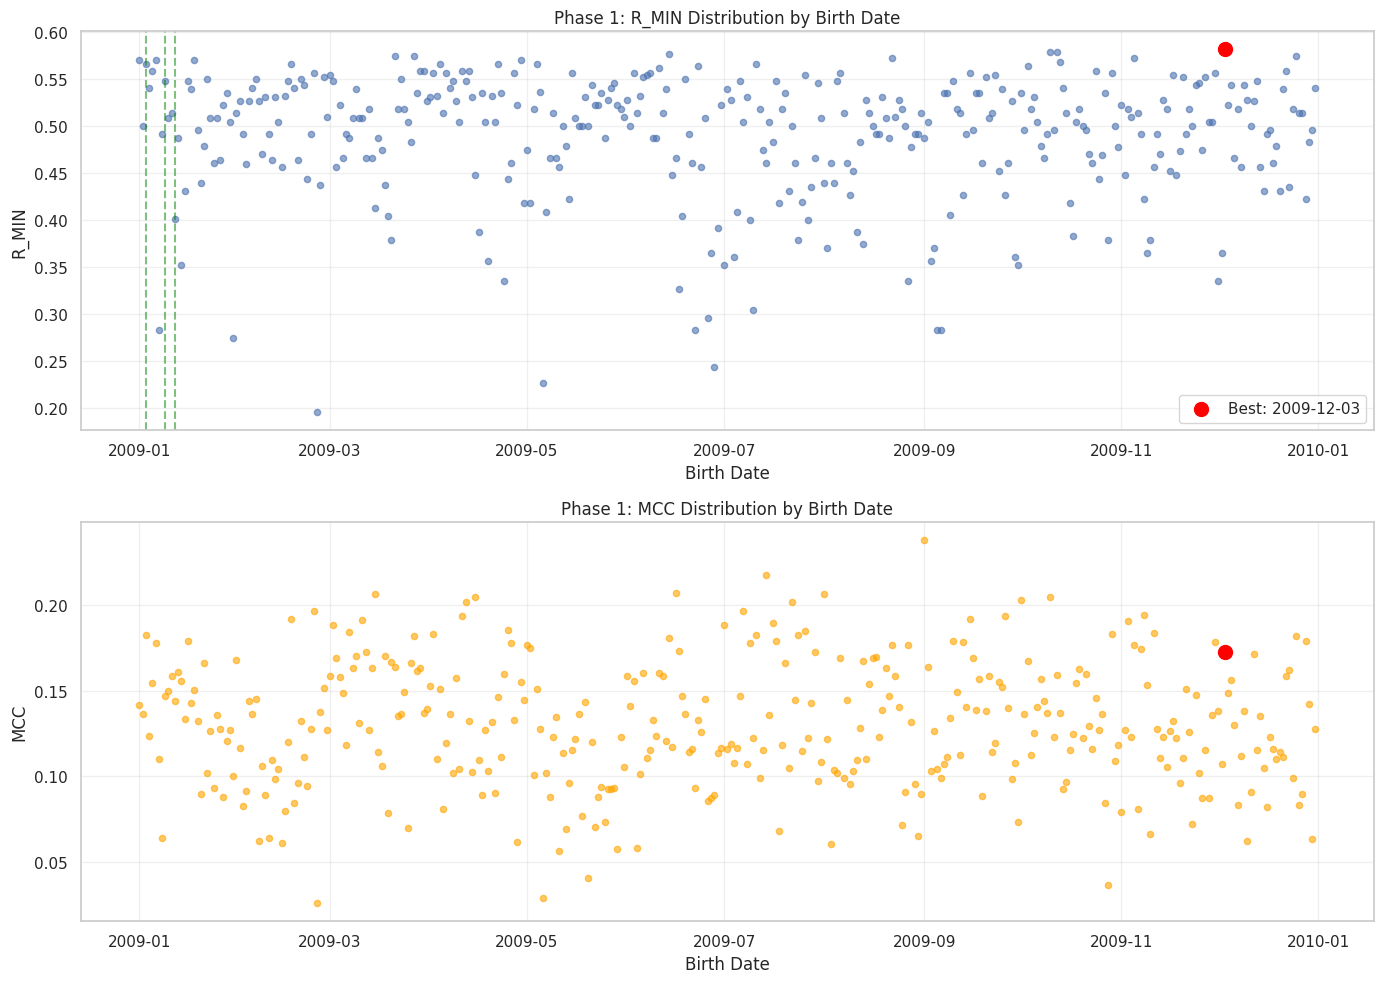

In [16]:
# График распределения R_MIN по датам
if len(df_results1) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: R_MIN by date
    ax1 = axes[0]
    dates = pd.to_datetime(df_results1["birth_date"])
    ax1.scatter(dates, df_results1["recall_min"], alpha=0.6, s=20)
    
    # Highlight best
    best_row = df_results1.iloc[0]
    ax1.scatter([pd.to_datetime(best_row["birth_date"])], [best_row["recall_min"]], 
                c='red', s=100, zorder=5, label=f"Best: {best_row['birth_date']}")
    
    # Mark known candidates
    for cd in CANDIDATE_DATES:
        if cd.year == BIRTH_YEAR:
            ax1.axvline(pd.to_datetime(cd), color='green', alpha=0.5, linestyle='--')
    
    ax1.set_xlabel("Birth Date")
    ax1.set_ylabel("R_MIN")
    ax1.set_title("Phase 1: R_MIN Distribution by Birth Date")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: MCC by date
    ax2 = axes[1]
    ax2.scatter(dates, df_results1["mcc"], alpha=0.6, s=20, c='orange')
    ax2.scatter([pd.to_datetime(best_row["birth_date"])], [best_row["mcc"]], 
                c='red', s=100, zorder=5)
    ax2.set_xlabel("Birth Date")
    ax2.set_ylabel("MCC")
    ax2.set_title("Phase 1: MCC Distribution by Birth Date")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [17]:
print("\n" + "=" * 80)
print("✅ BIRTH DATE SEARCH COMPLETE!")
print("=" * 80)



✅ BIRTH DATE SEARCH COMPLETE!
